For creating our Neural Network class, we will use the numpy library.
Let's also import matplotlib to plot our results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Network Layers

To improve modularity, we will divide our network into sequence of **Layers**.
Each layer will be responsible for calculating a small part of our network.

A typical two-layer neural network is set-up as follows:

Input -> First Linear Layer -> Activation Function -> Second Linear Layer -> Output

A forward pass in such a network involves flow of the input data from the *Input* to the *Output* layers.

A backward pass involves calculating the gradient of the error in the output layer, with respect to the output of the last layer and propagating that gradient through each from the *Output* to the *Input* layer.

Each layer can have a number of parameters and is responsible for calculating the error-gradient with respect to those parameters during the backward pass. They can then using those gradients to adjust their parameters as part of training using gradient descent.

In [16]:
class Layer:
    """
    A layer in the network can do one of the following four things:
    
    * forward pass: Accepts an input and generates an output.
    * backward pass: Accepts the gradient of a variable (usually Error) with respect to the output variable
                     and uses the chain rule to calculate the gradient with respect to the input variable
                     for this layer.                     
    * init_params: Initialze any parameters involved in this layer.
    * update_params: Update any parameters involved in this layer as part of the training process,
                     with the learning rate alpha.
    """

    def forward(self, input_data):
        raise NotImplementedError
        
    def backpropagate(self, next_gradient):
        raise NotImplementedError
        
    def init_params(self):
        pass
        
    def update_params(self, alpha):
        pass

### Linear Layer

This layer represents the linear connections of the output of the previous layer to this layer.
The connections have weights, represented by the $W$ matrix. Furthermore, a bias term $b$ is introduced. The output of this layer is then calculated as follows:

$$
Z = WX + b
$$

Following this equation, suppose we have the gradient of the error with respect to the output $Z$, represented as $\frac{\partial E}{\partial Z}$, then we can calculate the gradient with respect to the input $X$ as follows:

$$
\frac{\partial E}{\partial X} = \left(W^T \right) \left(\frac{\partial E}{\partial Z}\right)
$$

Furthermore, to update the parameters $W$ and $b$, we can calulate the error gradient with respect to these parameters as follows:

$$
\frac{\partial E}{\partial W} = \left(\frac{\partial E}{\partial Z}\right) \left(X^T \right)
\\
\frac{\partial E}{\partial b} = \left(\frac{\partial E}{\partial Z}\right)
$$

In [17]:
class Linear(Layer):
    """
    A linear layer calculates the linear equation WX + b,
    where W is the weight matrix, b is the bias and X is the input matrix.
    """

    def __init__(self, input_dim, output_dim):
        """
        input_dim: Dimension of each input data for this layer.
        output_dim: Dimension of each output data for this layer.
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # This is optional, but we initialize W and b when the layer is created.
        self.init_params()
        
    def forward(self, input_data):        
        # Calculate and return WX + b
        self.input = input_data
        return self.w * self.input + self.b
        
    def backward(self, next_gradient):
        # Besides calculating gradient with respect to the input (X),
        # we will also record the gradient with respect to the paramters (W and b) so
        # that we can update the parameters using these gradients.
        
        # Here, the output of this layer: Z = WX + B
        # next_gradient = Grad(E, Z)
    
        # Grad(E, W) = Grad(E, Z) Transpose(X)
        self.dw = next_gradient * self.input.T
        
        # Grad(E, b) = Grad(E, Z)
        # but since b is a column vector and next_gradient is a matrix, we will take sum of its columns.
        self.db = np.sum(next_gradient, axis=1)
        
        # Finally, Grad(E, Input=X) = Transpose(W) Grad(E, Z)
        return self.w.T * next_gradient
    
    def init_params(self):
        # Use Xavier Initialization:
        variance = 2 / (self.output_dim + self.input_dim)
        mean = 0
        sigma = np.sqrt(variance)
        
        # Dim(W) = output_dim X input_dim
        self.w = np.matrix(
            np.random.normal(mean, variance,
                             (self.output_dim, self.input_dim))
        )
        
        # Dim(b) = output_dim X b
        self.b = np.matrix(
            np.random.normal(mean, variance,
                             (self.output_dim, 1))
        )
    
    def update_params(self, alpha):
        # Use gradient descent to update the parameters.
        # Theta_new = Theta_old - Learning_rate * Gradient(E, Theta)
        self.w = self.w - alpha * self.dw
        self.b = self.b - alpha * self.db
        

### Activation Layer

This layer represents a simple mathematical function used to activate the neuron.

For an input $Z$, it simply calculates:

$$
A = f(Z)
$$

where $f(Z)$ can be sigmoid, ReLu or any other activation function and is applied element-wise.

Given the gradient of the error with respect to it's output $A$, represented as $\frac{\partial E}{\partial A}$, we can calculate the gradient with respect to it's input $Z$ as follows:

$$
\frac{\partial E}{\partial Z} = \left(\frac{\partial E}{\partial A}\right) * \left(f'(Z)\right)
$$

where $*$ represents element-wise multiplication and $f'(Z) = \frac{\partial f(Z)}{\partial Z}$.

In [18]:
class Activation(Layer):
    """
    An activation layer uses a mathematical function to transform input to the output.
    
    Each activation layer implements the following two functions:
    
    * apply: Apply the function to the input data.
    * apply_d: Apply the derivative of the function with respect to the input variable for given input data.
    """

    def forward(self, input_data):
        # Forward pass is simply applying the function f(Z) to the input variable Z, element-wise.
        self.input = input_data
        return self.apply(input_data)
    
    def backward(self, next_gradient):
        # Here, the output of this layer: A = f(Z)
        # next_gradient = Grad(E, A)
        
        # First calculate f'(Z)
        f_dash = self.apply_d(self.input)
        
        # Finally, Grad(E, Input=Z) = Grad(E, A) * f'(Z)
        # which is element-wise multiplication.
        return np.multiply(f_dash, next_gradient)
    
    def apply(self, data):
        raise NotImplementedError
        
    def apply_d(self, data):
        raise NotImplementedError

Following are two common activation functions.

In [20]:
class Sigmoid(Activation):
    """
    The Sigmoid activation function:
    
    f(Z) = 1 / (1 + exp(-z))
    f'(Z) = f(Z) (1 - f(Z))
    """
    def apply(self, data):
        return 1 / (1 + np.exp(-data))
    
    def apply_d(self, data):
        y = self.apply(data)
        return np.multiply(y, 1 - y)
    

class ReLu(Activation):
    """
    The ReLu activation function:
    
    f(Z) = 0 if Z <= 0 and Z otherwise.
    f'(Z) = 0 if Z <=0 and 1 otherwise.
    """
    def apply(self, data):
        y = np.copy(data)
        y[y <= 0] = 0
        return y
    
    def apply_d(self, data):
        y = np.ones(data.shape)
        y[data <= 0] = 0
        return y

## Multiclass Feed-Forward Neural Network

We can create any architecture of neural network using the above layers. To use a sequence of layers for multiclass classification purpose, we will setup our neural network with following features:

**Softmax output**

The output of the network is N-size vectors where N is the number of classes and the vector elements are unbounded numbers. Since we have multiple classes to output, we will transform these unbounded numbers to probability of being in different classes using the softmax approach. The softmax function is given as:
    
$$
p(y_i) = \frac{e^{y_i}}{\sum_{j=1}^N{e^{y_j}}}
$$
    
**Mini-batch training**

To train the data, we will iterate over some given number of epochs and use gradient descent with backpropagation. However, using one input-output training pair for training pass will result in really slow convergence (and even slower computation in python). But since the training size can be very large, we might not be able to train using the whole data at once either. So as a compromise, we will separate the training data into mini-batches each of (at most) given size and train one mini-batch at a time.
    
**Cross-Entropy error**

We want to calculate the error of our neural network as it trains to see how it is improved over the training epochs. We also want to calculate the error using some test data, to report the final accuracy of our trained network. For this purpose, since we are dealing with probabilities as output, we will use cross-entropy error. The error of classifying a test data $x$ is given as:
    
$$
Error(x) = \sum_i{-t_i log(p_i)}
$$
    
where $p_i$ is the i-th output probability from the neural network (calculated using softmax) and $t_i = 1$ if $x$ belong to class $i$ and $t_i = 0$ otherwise. This error is summed over all the test data to calculate total error.
    

In [60]:
class Network(Layer):
    """
    A simple feed-forward multi-class neural network.
    
    This network is capable of calculating the probability of an input data to be in one of several classes
    using softmax function to calculate the probability.
    """

    def __init__(self, layers, num_classes, learning_rate):
        """
        layers: List of neural network layers in sequence.
        num_classes: Number of output classes.
        learning_rate: Learning rate to use with the gradient descent during training of the network parameters.
        """
        self.layers = layers
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        
    def forward(self, input_data):
        """
        Forward pass an input data through each layer in the network and return the output.
        """
        next_data = input_data
        for layer in self.layers:
            next_data = layer.forward(next_data)
        return next_data
    
    def backward(self, last_gradient):
        """
        Backpropagatet a gradient (usually the error gradient) with respect to the network output
        through each layer from the last.
        """
        for layer in reversed(self.layers):
            last_gradient = layer.backward(last_gradient)
        return last_gradient
        
    def init_params(self):
        """
        Initialize each layer's parameters.
        """
        for layer in self.layers:
            layer.init_params()

    def update_params(self, alpha):
        """
        Update each layer's parameters using gradient descent with the learning rate of alpha.
        """
        for layer in self.layers:
            layer.update_params(alpha)
            
    def train(self, input_data, target_data, num_epochs, batch_size):
        """
        Train over the given input and target matrices, taking mini-batches of given size and for given
        number of epochs.
        """
        
        # First transform the input and output matrices to the format acceptable to out network.
        # This means, tranposing the input document matrix to get X
        # and one-hot encoding the output matrix to get Y.
        X, T = self.preprocess(input_data, target_data)
        
        # At this point, each column of X and T represent one pair of input-output data and the whole matrices
        # represent the complete batch.
        
        num_items = len(input_data)
        
        # We will collect the errors over each epoch and each mini batch, which is useful for plotting later.
        errors = []
        batch_errors = []
        
        for epoch in range(num_epochs):
            # For each epoch, shuffle the training data.
            
            # Create a shuffled indices array.
            indices = np.arange(num_items)
            np.random.shuffle(indices)
            
            # Shuffle the data around. Note that we need to shuffle the columns.
            # Also, we must shuffle the X and T both the same way so the corresponding pairs are always together.
            X = X[:, indices]
            T = T[:, indices]
            
            
            # Error for this epoch.
            epoch_error = 0
            
            # Take each mini-batch.
            for i in range(0, num_items, batch_size):

                # Feed the mini-batch forward.
                y = self.forward(X[:, i:i + batch_size])
                # Use softmax to calculate the probabilities of being in different classes.
                p = self.softmax(y)
                
                # The corresponding one-hot encoded target vectors.
                t = T[:, i:i + batch_size]
    
                # Calculate the error between the output and the target for this mini-batch.
                error = self.calc_error(p, t)
                batch_errors.append(error)
                epoch_error += error
                
                # For cross-entropy error,
                # Grad(Error, Output) = p - t
                grad_error = (p - t)
                
                # Back-propagate this gradient to each layer from the last.
                self.backward(grad_error)
                
                # Update the parameters of each layer using gradient descent.
                self.update_params(self.learning_rate)
                
            # Calculate mean error for this epoch.
            errors.append(epoch_error / i)
                
        # Return the errors.
        return errors, batch_errors
                
    def test(self, input_data, target_data):
        """
        Test the network using the pair of input and target matrices and calculate the errors.
        Can be used for validation and error reporting.
        """
        
        # Transform the input and target matrices just like we do in training.
        X, T = self.preprocess(input_data, target_data)
        
        # Forward pass the input through the network layers.
        y = self.forward(X)
        
        # Calculate the probability of the data to be in the different classes using softmax.
        p = self.softmax(y)
        
        # Calculate the error between the computed probabilites and the target vectors.
        return self.calc_error(p, T)
            
    def preprocess(self, input_data, target_data):
        """
        Given an input document matrix and their classes, create X and T matrices respectively in the format
        that can be used with this neural network.
        
        input_data: A matrix of input data where each row is a input vector.
        target_data: A list/array of numbers representing the class index of the corresponding input vector.
        """
    
        num_items = len(input_data)
        
        # Transpose the input_data to create X matrix.
        X = np.matrix(input_data).T
        
        # Use one-hot encoding to transform the target_data vector into Y matrix.
        T = np.zeros((self.num_classes, num_items))
        T[target_data, np.arange(num_items)] = 1
        T = np.matrix(T)
        
        # Return X and T.
        return X, T
    
    def softmax(self, y):
        """
        Use softmax function on the given matrix, over each column, to convert the values into probabilities.
        """
        # The real softmax function is:
        # exps = np.exp(y)
        # p = exps / Sum(exps)
        
        # However, sometimes the values of y can be very large and applying the exponential function
        # can result in overflow errors.
        
        # So, we can use a trick to get the same result, by subtracting a large value from each value in y.
        # For our purpose, we can subtract the maximum value in each y-column and take the exp and
        # get the same result without overflowing.
        exps = np.exp(y - y.max(axis=0))  # Originally: exps = np.exp(y)
        return exps / exps.sum(axis=0)
    
    def calc_error(self, y, t):
        """
        Given an output probability matrix y and corresponding target class matrix (one-hot encoded) t,
        calculate the error.
        """
        
        # Cross Entropy Error given by:
        # Error = 1 / M * Sum(-t log(y))
        j = np.sum(-np.multiply(t, np.log(y)))
        return float(j) / t.size
            

## Testing

Let's test the network using the MNIST dataset. First create a Two-Layer neural network using 100 neurons and sigmoid activation in the hidden layer. The input and output size for the MNIST dataset is 784 and 10 respectively.

In [61]:
network = Network([
    Linear(784, 100),
    Sigmoid(),
    Linear(100, 10),
], 10, 0.1)  # Learning rate = 0.1

network.init_params()

Import the mnist dataset and train over them. Note that normalizing the inputs to $[0, 1]$ range will help smooth out the training process because we don't want large values for sigmoid activations.

In [62]:
import mnist

x_train, t_train, x_test, t_test = mnist.load()
x_train, x_test = x_train / 255.0, x_test / 255.0

errors, batch_errors = network.train(x_train, t_train, 24, 64)

Plot the training errors, we can see how the network is converging towards the point where there's minimal error.

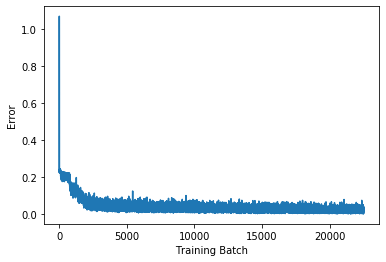

In [63]:
plt.xlabel('Training Batch')
plt.ylabel('Error')
plt.plot(batch_errors)

A cleaner plot is obtained when using mean errors over each epoch instead of each mini-batch.

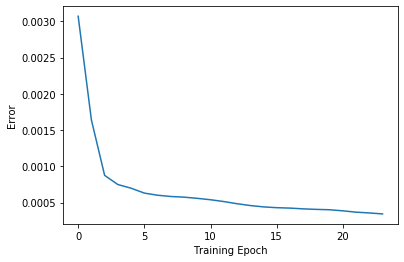

In [64]:
plt.xlabel('Training Epoch')
plt.ylabel('Error')
plt.plot(errors)

Let's test the accuracy of our network over a test dataset.

In [65]:
accuracy = 100 - network.test(x_test, t_test) * 100
print(f'Accuracy: {accuracy}%')


Accuracy: 97.43133006784201%


Not bad for simple feed forward network, specially since the inputs are images and we can probably do even better with a convolutional neural network.